In [40]:
from __future__ import absolute_import, division, print_function

# Histograms: rental times

## Imports

In [41]:
import datetime
import os

import numpy as np
import pandas as pd

from scipy import optimize
from dateutil.relativedelta import relativedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

## Data

In [42]:
data_dir = os.path.join(os.getcwd(),'..','..','data')
df = pd.read_csv(os.path.join(data_dir,'customer_tripdurations_histogram_2016.csv'))
df.head()

,bucket_floor,bucket_name,count
0,0,0 to 900,425454
1,900,900 to 1800,731853
2,1800,1800 to 2700,203399
3,2700,2700 to 3600,56573
4,3600,3600 to 4500,26379


In [43]:
df.describe()

,bucket_floor,count
count,6.090000e+02,609.000000
mean,5.271695e+05,2476.310345
std,7.566273e+05,35323.164368
min,0.000000e+00,1.000000
25%,1.368000e+05,1.000000
50%,2.853000e+05,2.000000
75%,5.787000e+05,8.000000
max,6.706800e+06,731853.000000


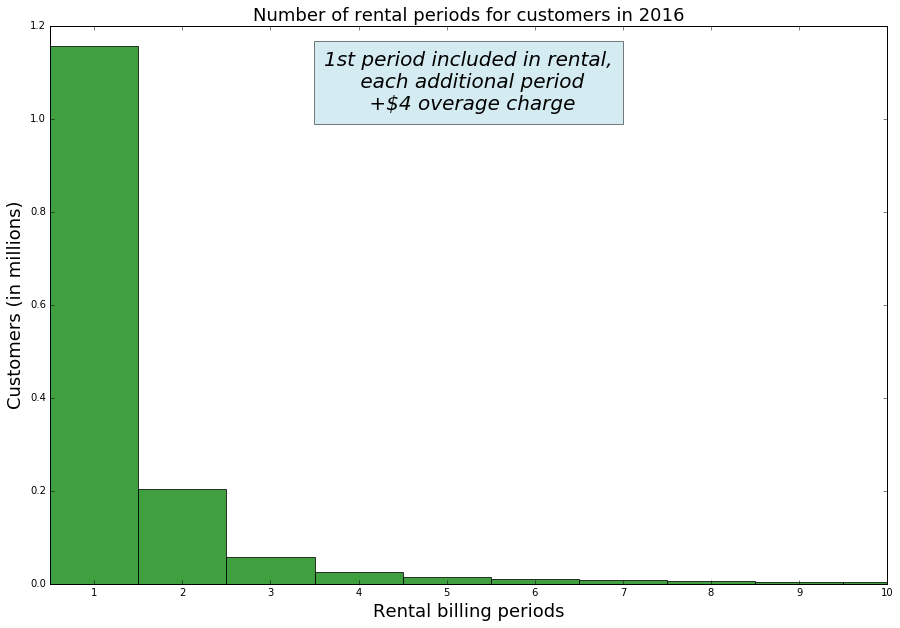

In [44]:
# What is the distribution of rental duration for the 'customer' cohort in 2016?
n_customers = df['count'][df['count'] >= 100].tolist()
n_customers = [x/1e6 for x in n_customers]
duration = df['bucket_floor'][df['count'] >= 100].tolist()
duration = [x/900 for x in duration] 
# account for the fact that the first usage period is 30min, whereas overage charges are billed per 15min (900s)
tmp_customers = n_customers[0]+n_customers[1]
n_customers = n_customers[2:]
n_customers.insert(0,tmp_customers)
tmp = duration.pop()
#
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(duration, n_customers, 1., color='g',align='center',alpha=0.75)
plt.xticks(xrange(len(duration)), [int(x+1) for x in duration])
plt.xlabel('Rental billing periods', fontsize=18)
plt.ylabel('Customers (in millions)', fontsize=18)
plt.title('Number of rental periods for customers in 2016', fontsize=18)
plt.xlim(-0.5,9)
# plt.grid(True)
# ax.tick_params(labelsize=18)
# 
# ax.annotate('1st period included in rental,\n each additional period\n $4 overage charge', xy=(0.5, 0.85),xycoords='axes fraction',horizontalalignment='center',
#             fontsize=20)

ax.text(0.5, 0.85, '1st period included in rental,\n each additional period\n +$4 overage charge', style='italic',
        horizontalalignment='center', bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10},
        transform=ax.transAxes,fontsize=20)

plt.show()



In [45]:
df = pd.read_csv(os.path.join(data_dir,'subscriber_tripdurations_histogram_2016.csv'))
df.head()

,bucket_floor,bucket_name,count
0,0,0 to 900,8890782
1,900,900 to 1800,2745016
2,1800,1800 to 2700,560627
3,2700,2700 to 3600,60874
4,3600,3600 to 4500,13470


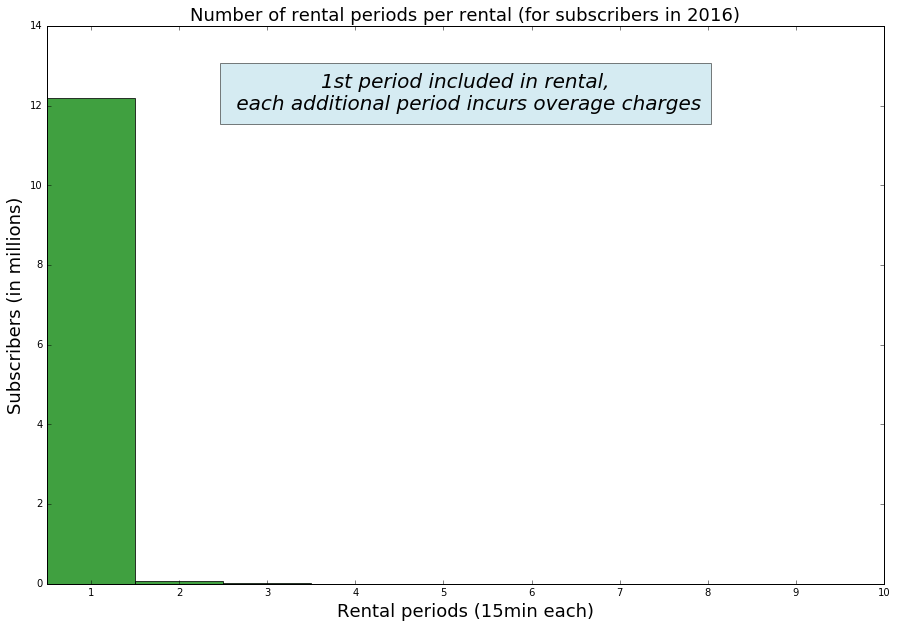

In [46]:
# What is the distribution of rental duration for the 'customer' cohort in 2016?
n_customers = df['count'][df['count'] >= 100].tolist()
n_customers = [x/1e6 for x in n_customers]
duration = df['bucket_floor'][df['count'] >= 100].tolist()
duration = [x/900 for x in duration] 
n_customers = []
for idx,dur in enumerate(duration):
    if idx == 0:
        n_customers.append(df['count'].iloc[idx])
    elif idx <=2:
        n_customers[0] += df['count'].iloc[idx]
    else:
        if idx%2 != 0:
            n_customers.append(df['count'].iloc[idx])
        else:
            n_customers[-1] += df['count'].iloc[idx]
new_duration = np.arange(len(n_customers))
n_customers = [x/1e6 for x in n_customers]
#
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(new_duration, n_customers, 1., color='g',align='center',alpha=0.75)
plt.xticks(xrange(len(new_duration)), [int(x+1) for x in new_duration])
plt.xlabel('Rental periods (15min each)', fontsize=18)
plt.ylabel('Subscribers (in millions)', fontsize=18)
plt.title('Number of rental periods per rental (for subscribers in 2016)', fontsize=18)
plt.xlim(-0.5,9)
# plt.grid(True)
# ax.tick_params(labelsize=18)
ax.text(0.5, 0.85, '1st period included in rental,\n each additional period incurs overage charges', style='italic',
        horizontalalignment='center', bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10},
        transform=ax.transAxes,fontsize=20)

plt.show()




## Month/month growth in annual subscriptions

In [47]:
df = pd.read_csv(os.path.join(data_dir,'citibike_sales.csv'))
df.head()

,year,month,yearly,weekly,three_day,daily,casual,active_annual_members
0,2013,6,26515,8044,0,67794,75838,52130
1,2013,7,14185,5980,0,49021,55001,66315
2,2013,8,10823,5244,0,51637,56881,77138
3,2013,9,8103,4634,0,52045,56679,85241
4,2013,10,7901,3386,0,34234,37620,93124


In [48]:
# convert year and month to datetime object
df['date'] = df['year'].apply(str) + '-' + df['month'].apply(str)
df['date'] = df['date'].apply(pd.to_datetime)

In [49]:
# Calculate m/m change in % of active_annual_members
df['mth_over_mth'] = 0
for idx in range(df.shape[0]-1):
    tmp = ((df['active_annual_members'].iloc[idx+1] - 
            df['active_annual_members'].iloc[idx]) / 
           df['active_annual_members'].iloc[idx]) * 100
    df['mth_over_mth'].iloc[idx+1] = tmp
    
    

In [50]:
df.head()

,year,month,yearly,weekly,three_day,daily,casual,active_annual_members,date,mth_over_mth
0,2013,6,26515,8044,0,67794,75838,52130,2013-06-01,0.000000
1,2013,7,14185,5980,0,49021,55001,66315,2013-07-01,27.210819
2,2013,8,10823,5244,0,51637,56881,77138,2013-08-01,16.320591
3,2013,9,8103,4634,0,52045,56679,85241,2013-09-01,10.504550
4,2013,10,7901,3386,0,34234,37620,93124,2013-10-01,9.247897


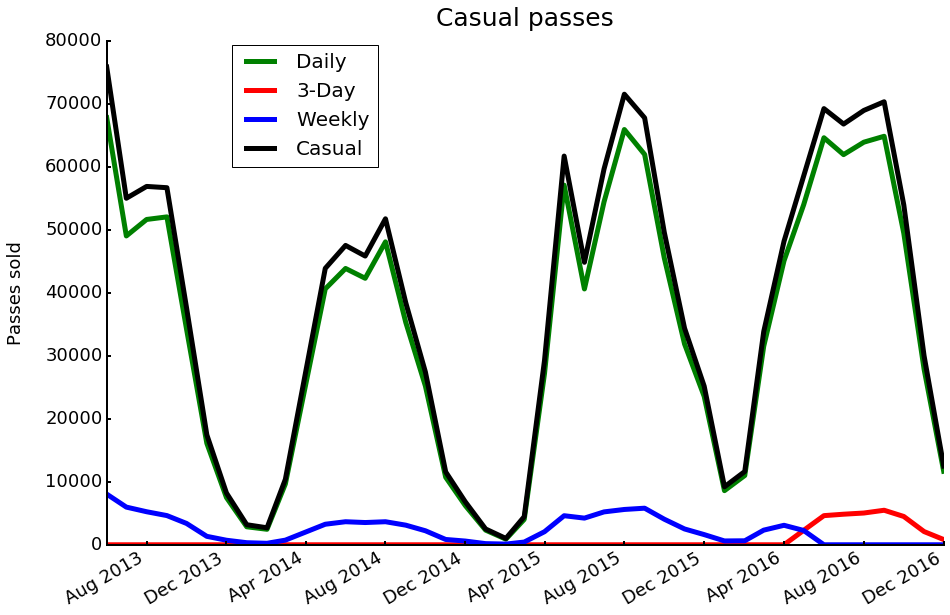

In [51]:
dates = df['date'][df['active_annual_members'] > 0].tolist()
weekly = df['weekly'][df['active_annual_members'] > 0].tolist()
daily = df['daily'][df['active_annual_members'] > 0].tolist()
three_day = df['three_day'][df['active_annual_members'] > 0].tolist()
casual = df['casual'][df['active_annual_members'] > 0].tolist()



fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,daily,'g-', alpha=1,lw=5, label='Daily')
plt.plot(dates,three_day,'r-', alpha=1,lw=5, label='3-Day')
plt.plot(dates,weekly,'b-', alpha=1,lw=5, label='Weekly')
plt.plot(dates,casual,'k-', alpha=1,lw=5, label='Casual')



# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('Casual passes', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.legend(prop={'size': 20},loc=(0.15,0.75))



### Casual pass numbers are dominated by daily passes.

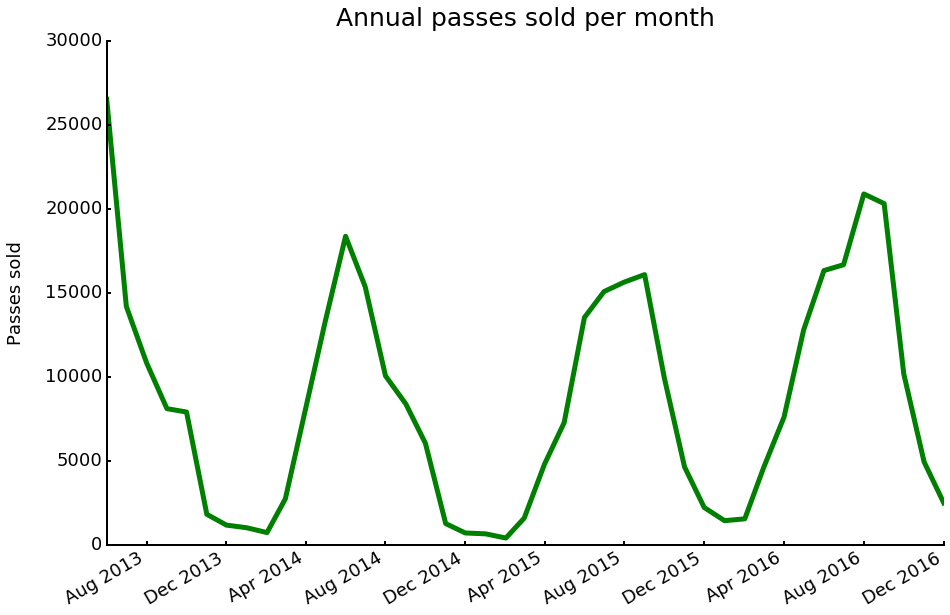

In [52]:
dates = df['date'][df['active_annual_members'] > 0].tolist()
yearly = df['yearly'][df['active_annual_members'] > 0].tolist()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,yearly,'g-', alpha=1,lw=5)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('Annual passes sold per month', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')





In [53]:
# N = len(yearly) # number of data points
# t = np.linspace(0, 6.5*np.pi, N)
# # data = 3.0*np.sin(t+0.001) + 0.5 + np.random.randn(N) # create artificial data with noise

# guess_mean = np.mean(yearly) 
# guess_std = 3*np.std(yearly)/(2**0.5) / 1.5 # Amplitude
# guess_phase = 2.5
# guess_slope = 1.2
# guess_offset = 0

# # we'll use this to plot our first estimate. This might already be good enough for you
# data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean

# # Define the function to optimize, in this case, we want to minimize the difference
# # between the actual data and our "guessed" parameters
# optimize_func = lambda x: x[0]*np.sin(t+x[1]) + x[2] + x[3]*t + x[4] - yearly 
# est_std, est_phase, est_mean, est_slope, est_offset = leastsq(optimize_func, [guess_std, guess_phase, guess_mean,guess_slope,guess_offset])[0]

# # recreate the fitted curve using the optimized parameters
# data_fit = est_std*np.sin(t+est_phase) + est_mean +est_slope*t +  est_offset

# print(est_std, est_phase, est_mean, est_slope, est_offset)

# plt.plot(yearly, '.')
# plt.plot(data_fit, label='after fitting')
# plt.plot(data_first_guess, label='first guess')
# plt.legend()
# plt.show()



## Fit data

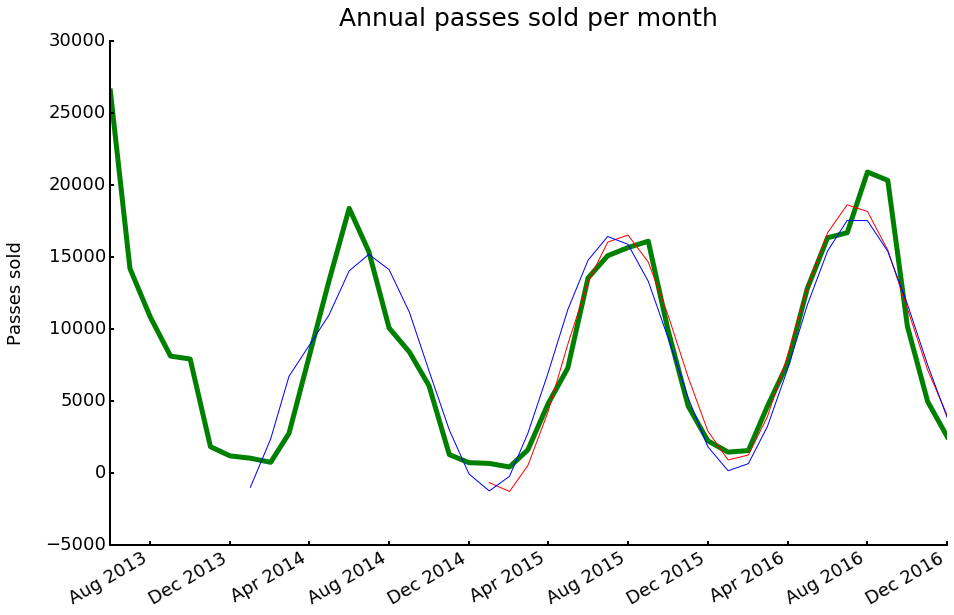

In [54]:
dates = df['date'][df['active_annual_members'] > 0].tolist()
yearly = df['yearly'][df['active_annual_members'] > 0].tolist()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,yearly,'g-', alpha=1,lw=5)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('Annual passes sold per month', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Fit data
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2015)].tolist()
yearly = df['yearly'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2015)].tolist()

# Generate data points with noise
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
tX = yearly

# We now have two sets of data: Tx and Ty, the time series, and tX and tY, 
# sinusoidal data with noise. We are interested in finding the frequency of the sine wave.
# Fit the first set
fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
p0 = [10000, 01.0, 4.5, 1000.] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))
#
time = np.linspace(Tx.min(), Tx.max(), 100)
plt.plot(dates, fitfunc(p1, Tx), "r-")  # Plot of the fit
# plt.plot(dates, fitfunc(p0, Tx), "b-") # Plot of the guess


# Fit data
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2014)].tolist()
yearly = df['yearly'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2014)].tolist()

# Generate data points with noise
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
tX = yearly

# We now have two sets of data: Tx and Ty, the time series, and tX and tY, 
# sinusoidal data with noise. We are interested in finding the frequency of the sine wave.
# Fit the first set
fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
p0 = [10000, 01.0, 4.5, 1000.] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))
#
time = np.linspace(Tx.min(), Tx.max(), 100)
plt.plot(dates, fitfunc(p1, Tx), "b-")  # Plot of the fit



## Fit data with changing amplitude

[ 268.50657722   12.            5.0563073   269.29416405]


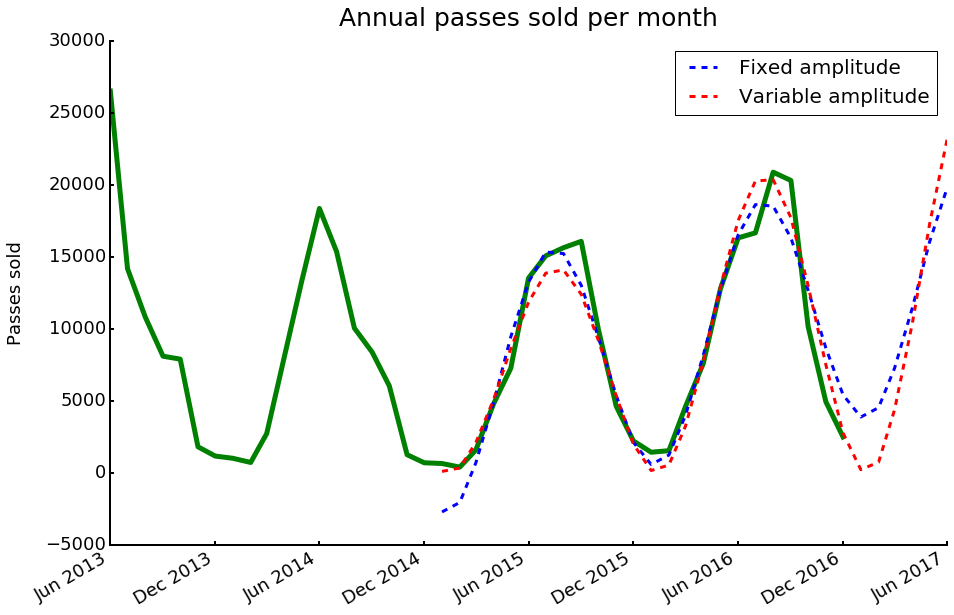

In [55]:
dates = df['date'][df['active_annual_members'] > 0].tolist()
yearly = df['yearly'][df['active_annual_members'] > 0].tolist()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,yearly,'g-', alpha=1,lw=5)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('Annual passes sold per month', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Fit data - Same amplitude
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2015)].tolist()
yearly = df['yearly'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2015)].tolist()
# data points
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
Tx = np.arange(num_points)
shp = df['date'].shape
Tx = [np.abs(x-shp[0]) for x in Tx]
Tx = np.array(Tx[::-1])
tX = yearly
# Fit functions
fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x # Target function
fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/12.*x+p[2]) + p[3]*x # Target function, fixed period
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
# p0 = [10000, 01.0, 4.5, 1000.] # Initial guess for the parameters
p0 = [8e3, 11.5, 4.2, 300.] 
# amplitude, frequency,  , slope
# perform fit
p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))
#
new_x = dates[:]
add_months = np.arange(6)
for i in add_months:
    new_x.append(new_x[-1] + relativedelta(months=1))
num_points = len(new_x)
new_Tx = np.arange(num_points)
new_Tx = [x+Tx[0] for x in new_Tx]
new_Tx = np.array(new_Tx)
# plt.plot(dates, fitfunc(p0, Tx), "b-", label='Fixed amplitude')  # Plot of the fit
plt.plot(new_x, fitfunc(p1, new_Tx), "b--", lw=3, label='Fixed amplitude')  # Plot of the fit
# plt.plot(dates, fitfunc(p0, Tx), "b-") # Plot of the guess

# Fit data - Variable amplitude
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2015)].tolist()
yearly = df['yearly'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2015)].tolist()
# data points
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
Tx = np.arange(num_points)
shp = df['date'].shape
Tx = [np.abs(x-shp[0]) for x in Tx]
Tx = np.array(Tx[::-1])
tX = yearly
# Fit functions
fitfunc = lambda p, x: p[0]*x*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x # Target function
fitfunc = lambda p, x: p[0]*x*np.cos(2*np.pi/12.*x+p[2]) + p[3]*x # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
# p0 = [1000, 1.5, 19.5, 1000.] # Initial guess for the parameters
p0 = [250, 12., 4.2, 300.] 
# perform fit
p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))
#
new_x = dates[:]
add_months = np.arange(6)
for i in add_months:
    new_x.append(new_x[-1] + relativedelta(months=1))
num_points = len(new_x)
new_Tx = np.arange(num_points)
new_Tx = [x+Tx[0] for x in new_Tx]
new_Tx = np.array(new_Tx)
print(p1)
# plt.plot(dates, fitfunc(p1, Tx), "r-", label='Variable amplitude')  # Plot of the fit
plt.plot(new_x, fitfunc(p1, new_Tx), "r--", lw=3, label='Variable amplitude')  # Plot of the fit
# plt.plot(dates, fitfunc(p0, Tx), "b-") # Plot of the guess


plt.legend(prop={'size': 20})


[  922.36875124    12.             5.14441581  1262.73036999]


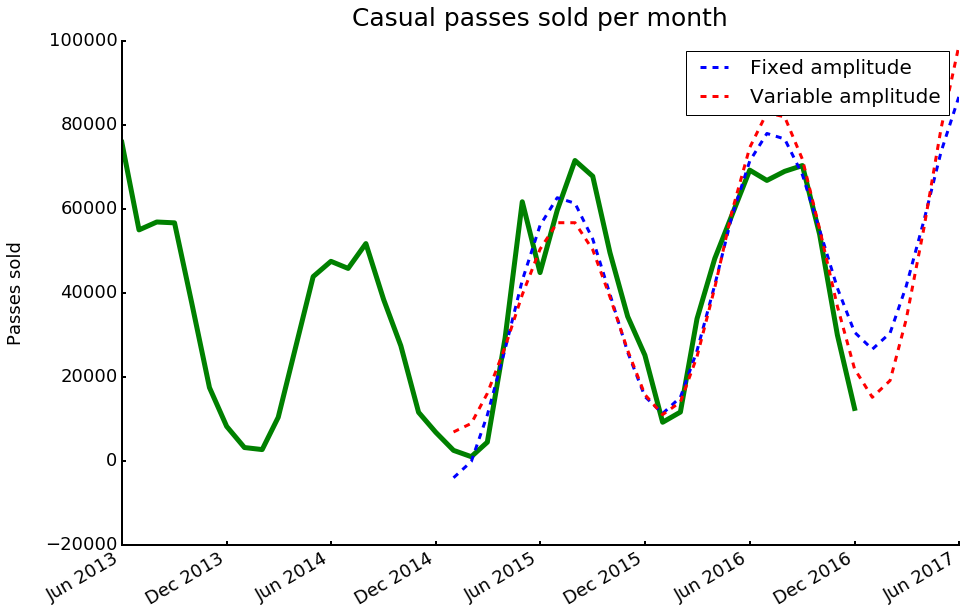

In [56]:
dates = df['date'][df['active_annual_members'] > 0].tolist()
yearly = df['casual'][df['active_annual_members'] > 0].tolist()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,yearly,'g-', alpha=1,lw=5)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('Casual passes sold per month', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Fit data - Same amplitude
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2015)].tolist()
yearly = df['casual'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2015)].tolist()
# data points
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
Tx = np.arange(num_points)
shp = df['date'].shape
Tx = [np.abs(x-shp[0]) for x in Tx]
Tx = np.array(Tx[::-1])
tX = yearly
# Fit functions
fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x # Target function
fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/12.*x+p[2]) + p[3]*x # Target function, fixed period
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
# p0 = [10000, 01.0, 4.5, 1000.] # Initial guess for the parameters
p0 = [8e3, 11.5, 4.2, 300.] 
# amplitude, frequency,  , slope
# perform fit
p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))
#
new_x = dates[:]
add_months = np.arange(6)
for i in add_months:
    new_x.append(new_x[-1] + relativedelta(months=1))
num_points = len(new_x)
new_Tx = np.arange(num_points)
new_Tx = [x+Tx[0] for x in new_Tx]
new_Tx = np.array(new_Tx)
# plt.plot(dates, fitfunc(p0, Tx), "b-", label='Fixed amplitude')  # Plot of the fit
plt.plot(new_x, fitfunc(p1, new_Tx), "b--", lw=3, label='Fixed amplitude')  # Plot of the fit
# plt.plot(dates, fitfunc(p0, Tx), "b-") # Plot of the guess

# Fit data - Variable amplitude
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2015)].tolist()
yearly = df['casual'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2015)].tolist()
# data points
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
Tx = np.arange(num_points)
shp = df['date'].shape
Tx = [np.abs(x-shp[0]) for x in Tx]
Tx = np.array(Tx[::-1])
tX = yearly
# Fit functions
fitfunc = lambda p, x: p[0]*x*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x # Target function
fitfunc = lambda p, x: p[0]*x*np.cos(2*np.pi/12.*x+p[2]) + p[3]*x # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
# p0 = [1000, 1.5, 19.5, 1000.] # Initial guess for the parameters
p0 = [250, 12., 4.2, 300.] 
# perform fit
p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))
#
new_x = dates[:]
add_months = np.arange(6)
for i in add_months:
    new_x.append(new_x[-1] + relativedelta(months=1))
num_points = len(new_x)
new_Tx = np.arange(num_points)
new_Tx = [x+Tx[0] for x in new_Tx]
new_Tx = np.array(new_Tx)
print(p1)
# plt.plot(dates, fitfunc(p1, Tx), "r-", label='Variable amplitude')  # Plot of the fit
plt.plot(new_x, fitfunc(p1, new_Tx), "r--", lw=3, label='Variable amplitude')  # Plot of the fit
# plt.plot(dates, fitfunc(p0, Tx), "b-") # Plot of the guess


plt.legend(prop={'size': 20})



## Fit data with Gaussian

In [57]:
#Gaussian function
def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
def double_gauss(x, a, b, x0, sigma, m, off):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)) +
            a*b*np.exp(-(x-x0-12.)**2/(2*sigma**2)) +
            m*x+off)
def double_gauss_nooff(x, a, b, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)) +
            a*b*np.exp(-(x-x0-12.)**2/(2*sigma**2)))

# def double_gauss(x, a, x0, sigma, m, off):
#     return (a*np.exp(-(x-x0)**2/(2*sigma**2)) +
#             a*np.exp(-(x-x0-12.)**2/(2*sigma**2)) +
#             m*x+off)

def triple_gauss(x, a, b, x0, sigma, m, off):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2))+
            a*b*np.exp(-(x-x0-12.)**2/(2*sigma**2))+
            b*a*b*np.exp(-(x-x0-12.-12.)**2/(2*sigma**2))+
            m*x+off)




[  1.66627330e+04   2.67343196e+01   2.26135828e+00]
[  1.68019035e+04   1.24423689e+00   2.65663114e+01   2.36858168e+00
   2.74958286e-10  -4.13651675e+02]
7.4053329158e-05


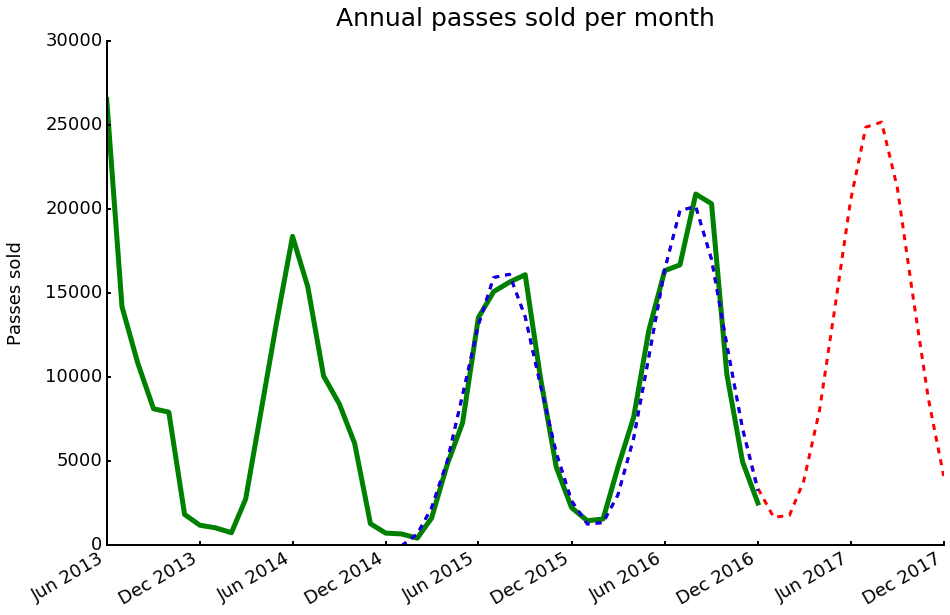

In [58]:
from scipy.optimize import curve_fit

# Plot data
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2013)].tolist()
yearly = df['yearly'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2013)].tolist()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,yearly,'g-', alpha=1,lw=5)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('Annual passes sold per month', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.ylim(0,30000)
plt.xlim(dates[0],dates[-1]+ relativedelta(months=12))




# Fit data
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2015)].tolist()
yearly = df['yearly'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2015)].tolist()


# data points
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
Tx = np.arange(num_points)
shp = df['date'].shape
Tx = [np.abs(x-shp[0]) for x in Tx]
Tx = np.array(Tx[::-1])
tX = yearly



# #estimate mean and standard deviation
# meam = sum(x * y)
# sigma = sum(y * (x - m)**2)
#do the fit!
p0 = [2e4,27,2]
popt, pcov = curve_fit(gauss, Tx, tX, p0 = p0)

# plt.plot(Tx,gauss(Tx, 2e4,27,2))
#plot the fit results
# plt.plot(Tx,gauss(Tx, *popt))
#confront with the given data
# plt.plot(Tx, tX,'ok')

print(popt)

param_bounds=([-np.inf,0,-np.inf],[np.inf,2,np.inf])
p0 = [1.7e4,1.3,27.,2.3,2.3,-400.]
param_bounds = ([1e4,1,25,0,0,-np.inf],
               np.inf)

# Constrain the optimization to the region of 0 < a < 3, 0 < b < 2 and 0 < c < 1:

# >>>
# >>> popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 2., 1.]))

popt, pcov = curve_fit(double_gauss, Tx, tX, bounds=param_bounds)
print(popt)
print(popt[1]/popt[0])
# plt.plot(Tx,double_gauss(Tx, *p0))

# plt.plot(dates,double_gauss(Tx, *popt),'b--',lw=3)

new_x = dates[:]
add_months = np.arange(12)
for i in add_months:
    new_x.append(new_x[-1] + relativedelta(months=1))
num_points = len(new_x)
new_Tx = np.arange(num_points)
new_Tx = [x+Tx[0] for x in new_Tx]
new_Tx = np.array(new_Tx)

plt.plot(new_x,triple_gauss(new_Tx, *popt),'r--',lw=3)
plt.plot(dates,double_gauss(Tx, *popt),'b--',lw=3)


plt.savefig(os.path.join(data_dir,'plots','monthly_variations_in_annual_passes_sold_03.pdf'), bbox_inches='tight')




In [59]:
1.68019035e+04*1.24423689e+00

20905.548156920115

In [60]:
1.68019035e+04*1.24423689e+00*2

41811.09631384023

[  5.08176795e+04   3.53010793e+01   1.14604596e+01]
[  1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.11271740e+03   5.98881869e+03]


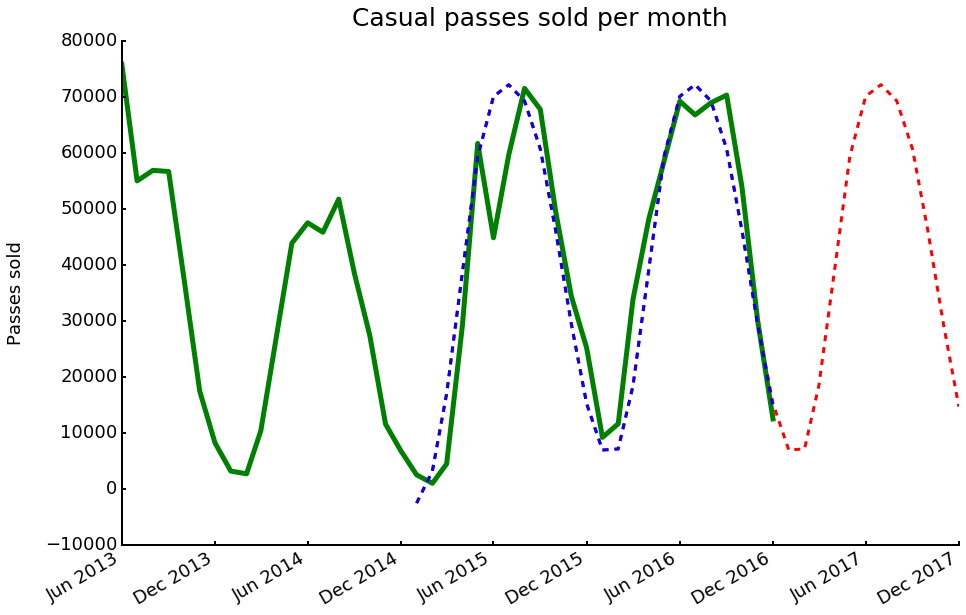

In [67]:
dates = df['date'][df['active_annual_members'] > 0].tolist()
casual = df['casual'][df['active_annual_members'] > 0].tolist()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,casual,'g-', alpha=1,lw=5)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('Casual passes sold per month', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Fit data
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2015)].tolist()
yearly = df['casual'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2015)].tolist()


# data points
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
Tx = np.arange(num_points)
shp = df['date'].shape
Tx = [np.abs(x-shp[0]) for x in Tx]
Tx = np.array(Tx[::-1])
tX = yearly



# #estimate mean and standard deviation
# meam = sum(x * y)
# sigma = sum(y * (x - m)**2)
#do the fit!
p0 = [2e4,27,2]
popt, pcov = curve_fit(gauss, Tx, tX, p0 = p0)
# plt.plot(dates,gauss(Tx, *popt),'r--',lw=3)


# plt.plot(Tx,gauss(Tx, 2e4,27,2))
#plot the fit results
# plt.plot(Tx,gauss(Tx, *popt))
#confront with the given data
# plt.plot(Tx, tX,'ok')

print(popt)

param_bounds=([-np.inf,0,-np.inf],[np.inf,2,np.inf])
p0 = [7.0e4,7.0e4,27.,2.5,0.3,-2400.]
p1 = [3.0e4,3.0e4,27.,1.5,0.3,-2400.]

# plt.plot(dates,double_gauss(Tx, *p0)+double_gauss(Tx+3, *p1),'m--',lw=3)
# plt.plot(dates,double_gauss(Tx+3, *p1),'y--',lw=3)

def double_gauss(x, a, b, x0, sigma, m, off):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)) +
            a*np.exp(-(x-x0-12.)**2/(2*sigma**2)) +
            m*x+off)



popt, pcov = curve_fit(double_gauss, Tx, tX)

print(popt)
# plt.plot(Tx,double_gauss(Tx, *p0))

# plt.plot(dates,double_gauss(Tx, *popt),'b--',lw=3)

new_x = dates[:]
add_months = np.arange(12)
for i in add_months:
    new_x.append(new_x[-1] + relativedelta(months=1))
num_points = len(new_x)
new_Tx = np.arange(num_points)
new_Tx = [x+Tx[0] for x in new_Tx]
new_Tx = np.array(new_Tx)

# plt.plot(new_x,triple_gauss(new_Tx, *popt),'r--',lw=3)
# plt.plot(dates,double_gauss(Tx, *popt),'b--',lw=3)

def triple_gauss(x, a, b, x0, sigma, m, off):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2))+
            b*np.exp(-(x-x0-12.)**2/(2*sigma**2))+
            b*np.exp(-(x-x0-12.-12.)**2/(2*sigma**2))+
            m*x+off)

plt.plot(new_x,triple_gauss(new_Tx, *p0)+triple_gauss(new_Tx+3, *p1),'r--',lw=3)
plt.plot(dates,double_gauss(Tx, *p0)+double_gauss(Tx+3, *p1),'b--',lw=3)

plt.savefig(os.path.join(data_dir,'plots','monthly_variations_in_casual_passes_sold_03.pdf'), bbox_inches='tight')




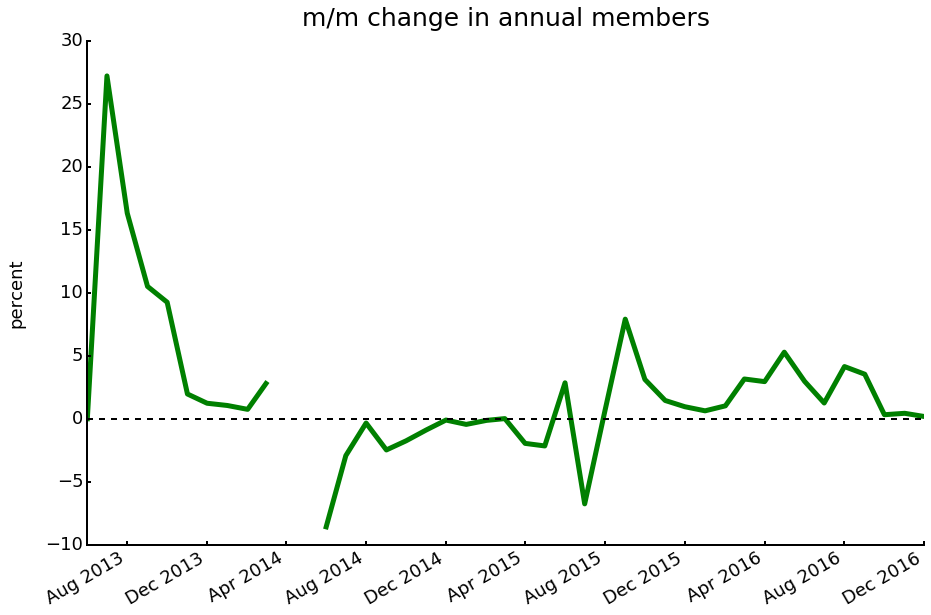

In [26]:
dates = df['date'][df['active_annual_members'] > 0].tolist()
rate = df['mth_over_mth'][df['active_annual_members'] > 0].tolist()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,rate,'g-', alpha=1,lw=5)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('percent', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('m/m change in annual members', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# highlight zero level
plt.plot([dates[0],dates[-1]],[0.,0.],ls='--',color='k',lw=2)



In [27]:
# Year-over-year growth in annual subscriptions
years = df['year'].unique().tolist()
growth = years[:]
for idx,year in enumerate(years):
    if idx == 0:
        growth[idx] = 0
    else:
        last_year = df['yearly'][df['year'] == years[idx-1]].sum()
        if years[idx-1] == 2013:
            # Account for the fact that for 2013 we only have data from June onwards.
            # The other years have a rateio of 1.3 for annual subscription for 
            # the full years vs. months 6 through 12.
            last_year = last_year * 1.3
        this_year = df['yearly'][df['year'] == years[idx]].sum()
        if years[idx-1] == 2014:
            # April 2014 missing. For 2015 and 2016, the annual subscriptions in April
            # are a factor of ~1.5 smaller than the annual subscriptions in May.
            last_year = last_year + 13303 / 1.5
        if years[idx] == 2014:
            this_year = this_year + 13303 / 1.5
        print(last_year,this_year)
        growth[idx] = (this_year-last_year)/last_year
    

91663.0 86818.6666667
86818.6666667 91832
91832 119758


In [28]:
growth = [x*100  for x in growth]


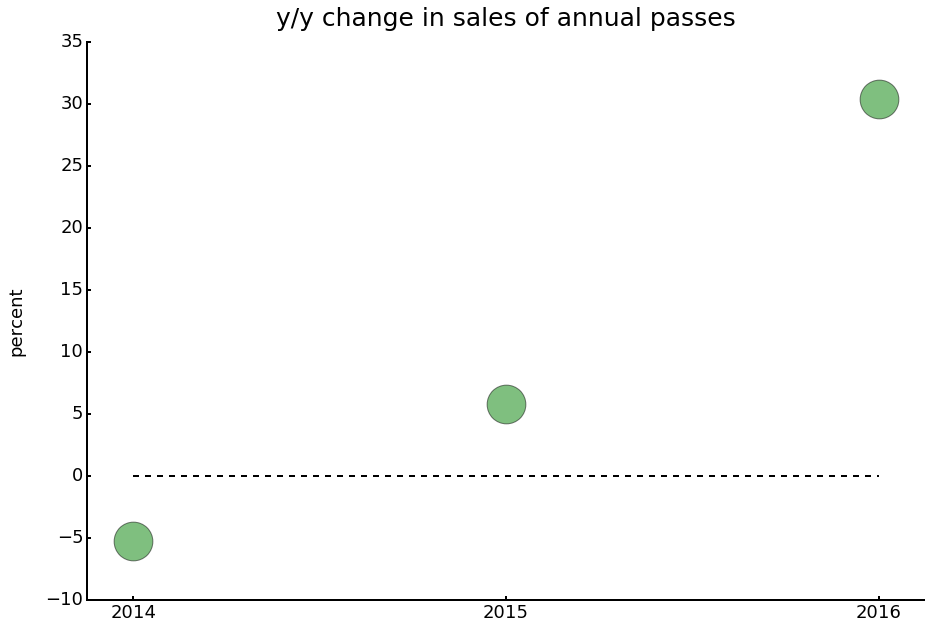

In [29]:

fig, ax = plt.subplots(figsize=(15, 10))
# plt.plot(years,growth,'g-', alpha=1,lw=5)
plt.scatter(years[1:],growth[1:], s=1500, c='green', alpha=0.5)
plt.xticks(years[1:], years[1:], horizontalalignment='center')
# rotate and align the tick labels so they look better
# fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
# ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('percent', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('y/y change in sales of annual passes', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# highlight zero level
plt.plot([2014,2016],[0.,0.],ls='--',color='k',lw=2)

plt.savefig(os.path.join(data_dir,'plots','year_over_year_change_of_annual_passes_sold.pdf'), bbox_inches='tight')



## Calculate per month the change in subscribers w.r.t. to the same month the year before

In [30]:
# Year-over-year growth in annual subscriptions
years = [2014,2015,2016]
months = list(np.arange(1,13))
growth_mom = []
for idx,year in enumerate(years):
    if year > 2014:
        for midx,month in enumerate(months):
            last_year = df['yearly'][(df['year'] == years[idx-1]) & 
                                     (df['month'] == month)].sum()
            this_year = df['yearly'][(df['year'] == years[idx]) & 
                                     (df['month'] == month)].sum()
            if years[idx-1] == 2014 and month == 4:
                # April 2014 missing. For 2015 and 2016, the annual subscriptions in April
                # are a factor of ~1.5 smaller than the annual subscriptions in May.
                last_year = 13303 / 1.5
            print(last_year,this_year,(this_year-last_year)/last_year)
            growth_mom.append((this_year-last_year)*100/last_year)



1013 651 -0.357354392892
726 402 -0.446280991736
2736 1589 -0.419225146199
8868.66666667 4799 -0.458881455311
13303 7268 -0.453657069834
18364 13528 -0.263341319974
15359 15073 -0.0186210039716
10055 15638 0.555246146196
8387 16081 0.917372123525
6043 9949 0.646367698163
1262 4633 2.67115689382
702 2221 2.16381766382
651 1435 1.20430107527
402 1543 2.83830845771
1589 4607 1.89930774072
4799 7598 0.58324650969
7268 12791 0.759906439185
13528 16322 0.206534594914
15073 16670 0.10595103828
15638 20884 0.335464893209
16081 20307 0.262794602326
9949 10167 0.0219117499246
4633 4939 0.0660479171163
2221 2495 0.123367852319


In [31]:
dates = df['date'][df['year'] > 2014].tolist()
print(len(dates))
print(len(growth_mom))

24
24


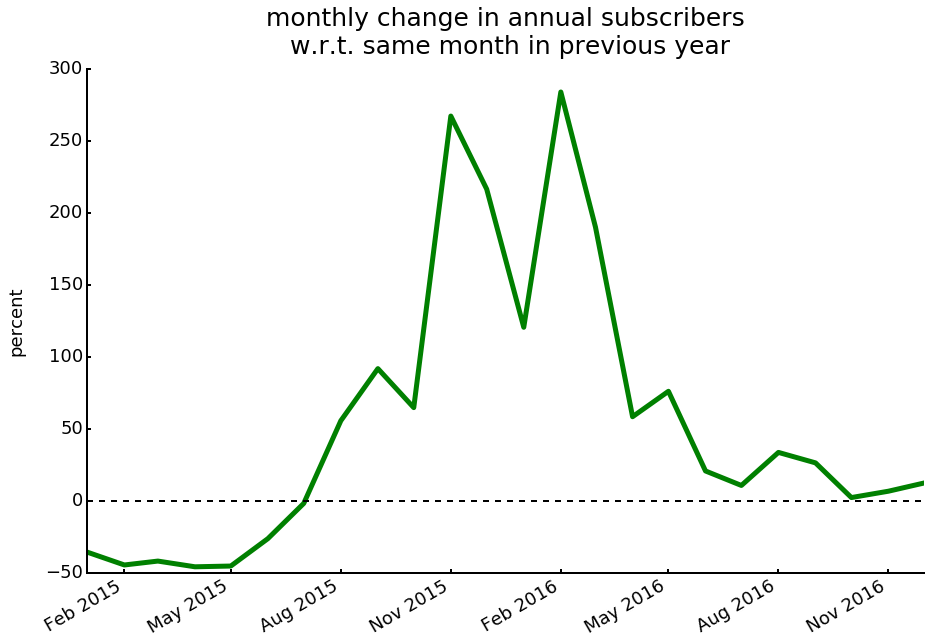

In [32]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,growth_mom,'g-', alpha=1,lw=5)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
plt.ylabel('percent', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('monthly change in annual subscribers\n w.r.t. same month in previous year', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# highlight zero level

# highlight zero level
plt.plot([dates[0],dates[-1]],[0.,0.],ls='--',color='k',lw=2)




## Weekly total rides for subscribers

In [33]:
df = pd.read_csv(os.path.join(data_dir,'weekly_totals_subscriber.csv'))
# convert year and month to datetime object
df['date'] = df['yr'].apply(str) + '-' + df['wk'].apply(str)
# df['date'] = df['date'].apply(pd.to_datetime)
df.head()

,yr,wk,n_rides,date
0,2013,1,22228,2013-1
1,2013,27,99636,2013-27
2,2013,28,136203,2013-28
3,2013,29,162488,2013-29
4,2013,30,175960,2013-30


In [34]:
rides = df['n_rides'][df['yr'] >= 2014].tolist()
dates = df['date'][df['yr'] >= 2014].tolist()

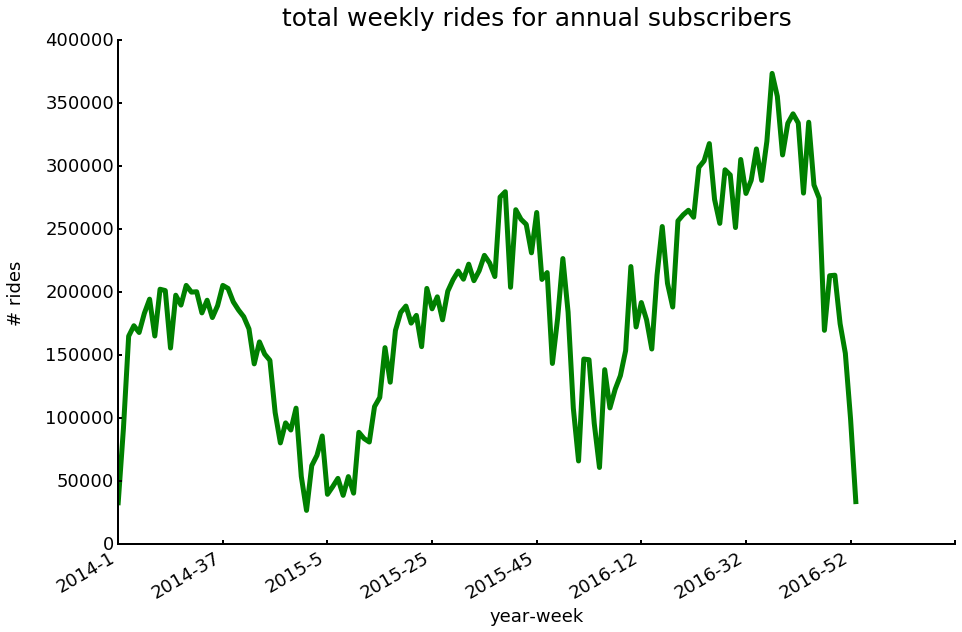

In [35]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.plot(range(len(dates)),rides,'g-', alpha=1,lw=5)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
plt.ylabel('# rides', fontsize=18)
plt.xlabel('year-week', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('total weekly rides for annual subscribers', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Change xtick labels
ticks = [x for x in ax.get_xticks()]
int_ticks = [int(x) for x in ticks]
label_dates = [dates[x] for x in int_ticks[:-1]]
ax.set_xticklabels(label_dates)


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')



## Weekly total rides for subscribers

In [36]:
df = pd.read_csv(os.path.join(data_dir,'weekly_totals_customers.csv'))
# convert year and month to datetime object
df['date'] = df['yr'].apply(str) + '-' + df['wk'].apply(str)
# df['date'] = df['date'].apply(pd.to_datetime)
df.head()

,yr,wk,n_rides,date
0,2013,1,1437,2013-1
1,2013,27,46735,2013-27
2,2013,28,36614,2013-28
3,2013,29,37008,2013-29
4,2013,30,39262,2013-30


In [37]:
rides = df['n_rides'][df['yr'] >= 2014].tolist()
dates = df['date'][df['yr'] >= 2014].tolist()

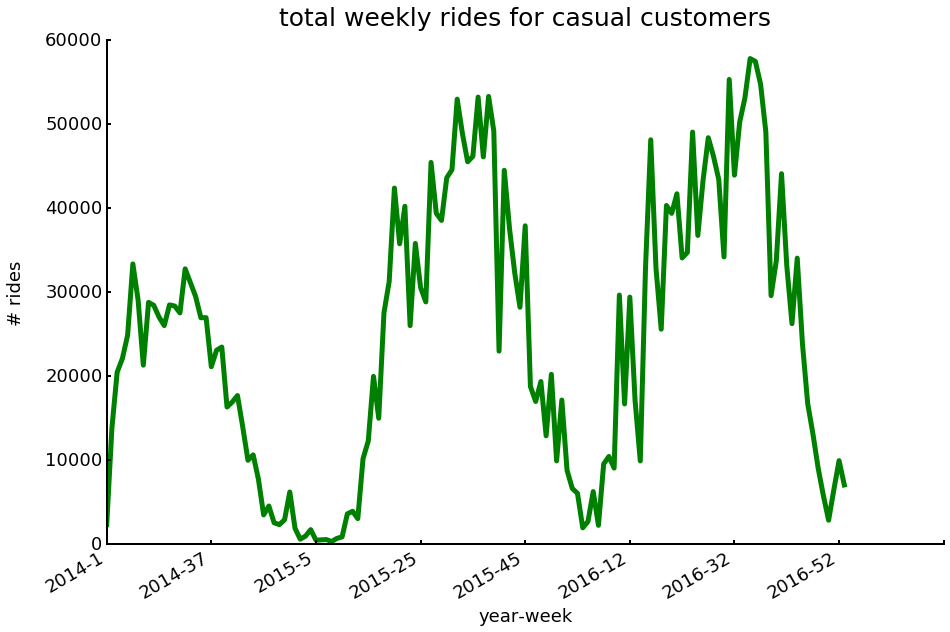

In [38]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.plot(range(len(dates)),rides,'g-', alpha=1,lw=5)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
plt.ylabel('# rides', fontsize=18)
plt.xlabel('year-week', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('total weekly rides for casual customers', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Change xtick labels
ticks = [x for x in ax.get_xticks()]
int_ticks = [int(x) for x in ticks]
label_dates = [dates[x] for x in int_ticks[:-1]]
ax.set_xticklabels(label_dates)


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')



## Check rides taken per annual customer

In [71]:
df_sales = pd.read_csv(os.path.join(data_dir,'citibike_sales.csv'))
df_rides = pd.read_csv(os.path.join(data_dir,'monthly_totals_subscriber.csv'))

In [72]:
# convert year and month to datetime object
df_sales['date'] = df_sales['year'].apply(str) + '-' + df_sales['month'].apply(str)
df_sales['date'] = df_sales['date'].apply(pd.to_datetime)
# convert year and month to datetime object
df_rides['date'] = df_rides['yr'].apply(str) + '-' + df_rides['mth'].apply(str)
df_rides['date'] = df_rides['date'].apply(pd.to_datetime)

In [73]:
df_sales.head()

,year,month,yearly,weekly,three_day,daily,casual,active_annual_members,date
0,2013,6,26515,8044,0,67794,75838,52130,2013-06-01
1,2013,7,14185,5980,0,49021,55001,66315,2013-07-01
2,2013,8,10823,5244,0,51637,56881,77138,2013-08-01
3,2013,9,8103,4634,0,52045,56679,85241,2013-09-01
4,2013,10,7901,3386,0,34234,37620,93124,2013-10-01


In [74]:
df_rides.head()

,yr,mth,n_rides,date
0,2013,7,668501,2013-07-01
1,2013,8,815902,2013-08-01
2,2013,9,889190,2013-09-01
3,2013,10,940266,2013-10-01
4,2013,11,631801,2013-11-01


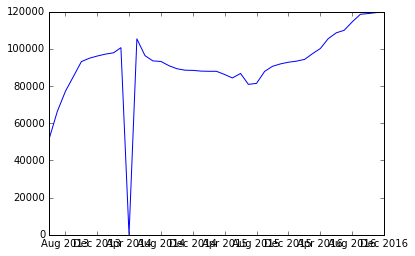

In [75]:
plt.plot(df_sales['date'],df_sales['active_annual_members'])

In [84]:
years = [2015,2016]
months = np.arange(12)+1
dates = []
ratios = []
for year in years:
    for month in months:
        condition = (df_sales['year'] == year) & (df_sales['month'] == month)
        tmp_aam = df_sales['active_annual_members'][condition].values
        dates.append(df_sales['date'][condition].values)
        condition = (df_rides['yr'] == year) & (df_rides['mth'] == month)
        tmp_nrides = df_rides['n_rides'][condition].values
        tmp_ratio = tmp_nrides/tmp_aam
        ratios.append(tmp_ratio)
        

In [85]:
print(dates)
print(ratios)

[array(['2015-01-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2015-02-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2015-03-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2015-04-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2015-05-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2015-06-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2015-07-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2015-08-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2015-09-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2015-10-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2015-11-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2015-12-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2016-01-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2016-02-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2016-03-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2

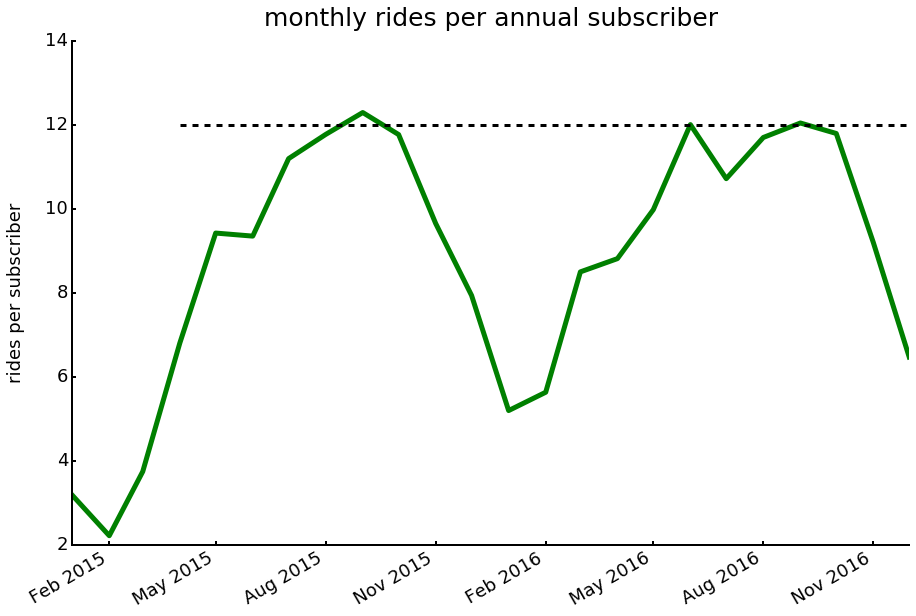

In [96]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.plot(dates,ratios,'g-', alpha=1,lw=5)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
plt.ylabel('rides per subscriber', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('monthly rides per annual subscriber', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.plot([dates[3],dates[-1]],[12,12],'k--',lw=3)

plt.savefig(os.path.join(data_dir,'plots','monthly_rides_per_subscriber.pdf'), bbox_inches='tight')

